
# Importing Libraries

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
plt.style.use('ggplot') #Setting style sheets that we're using for plot
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from scipy.stats import chi2_contingency

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
calls = pd.read_csv('calls.csv')
customers = pd.read_csv('customers.csv')
reason = pd.read_csv('reason.csv')
sentiment = pd.read_csv('sentiment_statistics.csv')


#  Frequency Of Primary Call Reasons

In [3]:
reason['primary_call_reason'].value_counts()

IRROPS                     13057
Voluntary Change           10291
Seating                     6223
Mileage Plus                5487
Post-Flight                 3869
Communications              3779
Products and Services       2792
Upgrade                     2682
Baggage                     2616
Booking                     2589
Checkout                    1840
Check-In                    1490
Voluntary Cancel            1304
Digital Support              996
ETC                          930
Traveler Updates             772
Schedule Change              707
Other Topics                 568
Products & Services          476
Disability                   394
Check In                     385
Post Flight                  373
Voluntary  Cancel            278
IRROPS                       254
Other  Topics                234
Voluntary Change             208
Voluntary   Change           200
Voluntary  Change            149
Seating                      142
Digital   Support            136
Mileage  P

Text(0, 0.5, 'Count')

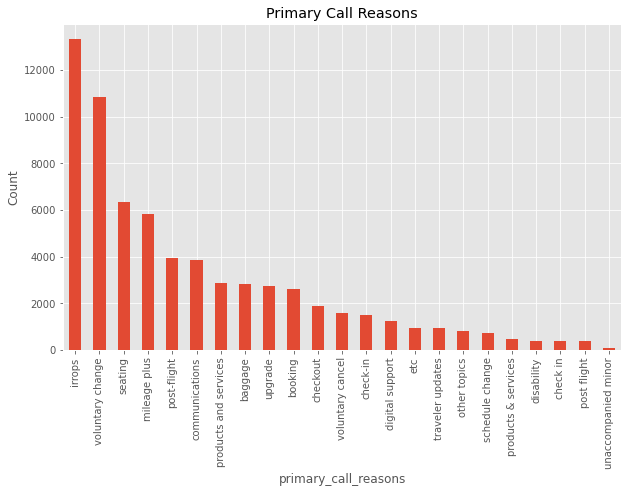

In [4]:
reason['primary_call_reason'] = (reason['primary_call_reason']
                .str.lower()                                  # Convert to lowercase
                .str.strip()                                  # Remove leading and trailing spaces
                .str.replace(r'\s+', ' ', regex=True))

reason['primary_call_reason'].value_counts()
call_reasons = reason['primary_call_reason'].value_counts()
plt.figure(figsize=(10, 6))
call_reasons.plot(kind='bar')
plt.title('Primary Call Reasons')
plt.xlabel('primary_call_reasons')
plt.ylabel('Count')

# - Here we see that most call reason are regarding IRROPS followed by voluntary change, seating, and mileage plus. 

- Here we can distribute some tasks so that customers can resolve such probles through mobile apps like IRROPS(Irregular operations) we can notify them about delays due to emergency or weather conditions. In case of diversions we need to asist them more thoroughly (door-to-door travel chain).After all, passengers’ trips don’t end right as they disembark.

In [5]:
sentiment_df = sentiment.groupby('agent_tone')['average_sentiment'].mean().reset_index()
sentiment_df

,agent_tone,average_sentiment
0,angry,-0.616478
1,calm,0.101289
2,frustrated,-0.329978
3,neutral,-0.080355
4,polite,0.673793


In [6]:
sentiment['agent_tone'].value_counts().to_frame()


,agent_tone
neutral,42758
calm,24675
frustrated,3684
angry,389
polite,87


In [7]:
sentiment['customer_tone'].value_counts().to_frame()

,customer_tone
neutral,14444
angry,14408
polite,14371
calm,14347
frustrated,14240


# Calculating Handle Time and Waiting Time

In [8]:
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'])

In [9]:
calls['Handle_Time'] = calls['call_end_datetime'] - calls['agent_assigned_datetime']
calls['Waiting_Time'] = calls['agent_assigned_datetime'] - calls['call_start_datetime']


In [10]:
# Define the maximum duration limit of 23:59:59
max_duration = pd.Timedelta(hours=1, minutes=59, seconds=59)

# Filter the DataFrame to find calls with duration longer than 23:59:59
long_calls = calls[calls['Handle_Time'] > max_duration]

# Display the long calls, if any
print(long_calls)

Empty DataFrame
Columns: [call_id, customer_id, agent_id, call_start_datetime, agent_assigned_datetime, call_end_datetime, call_transcript, Handle_Time, Waiting_Time]
Index: []


In [11]:
calls['Handle_Time'] = calls['Handle_Time'].apply(lambda x: str(x).replace('0 days ', '') if '0 days' in str(x) else str(x))
calls['Waiting_Time'] = calls['Waiting_Time'].apply(lambda x: str(x).replace('0 days ', '') if '0 days' in str(x) else str(x))

In [12]:
calls.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,00:31:00,00:07:00
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,00:12:00,00:03:00
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,00:19:00,00:08:00
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,00:07:00,00:05:00
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,00:09:00,00:10:00


# AHT (Average Handle Time) and AST(Average Speed to Answer)

In [13]:
calls['Handle_Time'] = pd.to_timedelta(calls['Handle_Time'])
tt_handle_time = calls['Handle_Time'].sum()

calls['Waiting_Time'] = pd.to_timedelta(calls['Waiting_Time'])
tt_waiting_time = calls['Waiting_Time'].sum()

In [14]:
time_delta_1 = pd.Timedelta(tt_handle_time)
time_delta_2 = pd.Timedelta(tt_waiting_time)

# Convert the timedelta to total minutes
total_handle_time = time_delta_1.total_seconds() / 60
total_waiting_time = time_delta_2.total_seconds() / 60

# Display the total minutes
print(f"Total Handle Time: {total_handle_time}")
print(f"Total Waiting Time: {total_waiting_time}")

Total Handle Time: 834251.0
Total Waiting Time: 523097.0


In [15]:
Total_calls = calls['call_id'].count()

AHT = round((total_handle_time/Total_calls), 1)
AST = round((total_waiting_time/Total_calls), 1)

print(f"AHT: {AHT}")
print(f"AST: {AST}")

AHT: 11.6
AST: 7.3


In [16]:
calls_sentiment = pd.merge(calls, sentiment, on='call_id', how='outer')
calls_sentiment = calls_sentiment.drop(columns=['agent_id_y'])
calls_sentiment.rename(columns={'agent_id_x': 'agent_id'}, inplace=True)
calls_sentiment.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:31:00,0 days 00:07:00,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:12:00,0 days 00:03:00,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:19:00,0 days 00:08:00,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:07:00,0 days 00:05:00,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:09:00,0 days 00:10:00,neutral,polite,-0.05,0.35


In [17]:

# Convert Handle_Time and Waiting_Time to timedelta if they are not already
calls_sentiment['Handle_Time'] = pd.to_timedelta(calls_sentiment['Handle_Time'])
calls_sentiment['Waiting_Time'] = pd.to_timedelta(calls_sentiment['Waiting_Time'])

# Create new columns representing the minutes
calls_sentiment['Handle_Time'] = calls_sentiment['Handle_Time'].dt.total_seconds() / 60
calls_sentiment['Waiting_Time'] = calls_sentiment['Waiting_Time'].dt.total_seconds() / 60

# Display the updated DataFrame with new columns
print(calls_sentiment[['Handle_Time', 'Waiting_Time']])


       Handle_Time  Waiting_Time
0             31.0           7.0
1             12.0           3.0
2             19.0           8.0
3              7.0           5.0
4              9.0          10.0
...            ...           ...
71805         28.0           9.0
71806          8.0           3.0
71807          6.0           6.0
71808          4.0           6.0
71809          3.0          10.0

[71810 rows x 2 columns]


In [18]:
relation = calls_sentiment
relation['Handle_Time'] = pd.to_numeric(
    relation['Handle_Time'])
relation['Waiting_Time'] = pd.to_numeric(
    relation['Waiting_Time'])

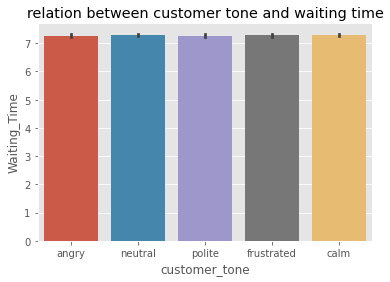

In [19]:
ax = sns.barplot(data=relation, x='customer_tone', y='Waiting_Time')
ax.set_title('relation between customer tone and waiting time')
plt.show()

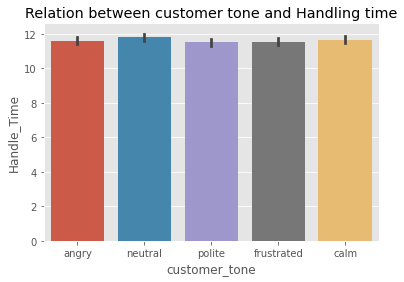

In [20]:
ax = sns.barplot(data=relation, x='customer_tone', y='Handle_Time')
ax.set_title('Relation between customer tone and Handling time')
plt.show()

In [21]:
correlation = calls_sentiment['silence_percent_average'].corr(calls_sentiment['average_sentiment'])

print("Pearson correlation between silence and average_sentiment:", correlation)

Pearson correlation between silence and average_sentiment: 0.03533890574144503


In [22]:
categorical_columns = ['agent_tone', 'customer_tone']
calls_sentiment_encoded = pd.get_dummies(calls_sentiment, columns=categorical_columns)

In [23]:
correlation_matrix = calls_sentiment[[
    'Handle_Time','Waiting_Time', 'agent_tone', 'customer_tone', 
    'average_sentiment', 'silence_percent_average']].corr()
correlation_matrix

,Handle_Time,Waiting_Time,average_sentiment,silence_percent_average
Handle_Time,1.000000,-0.027778,-0.076065,0.406883
Waiting_Time,-0.027778,1.000000,0.039881,-0.012068
average_sentiment,-0.076065,0.039881,1.000000,0.035339
silence_percent_average,0.406883,-0.012068,0.035339,1.000000


In [24]:
categorical_columns = ['agent_tone', 'customer_tone']
numeric_columns = ['average_sentiment', 'silence_percent_average']

# One-hot encode the categorical columns
df_encoded = pd.get_dummies(calls_sentiment, columns=categorical_columns)

# Calculate Pearson correlation (consider encoding other numeric columns if needed)
correlation_matrix = df_encoded.corr()
correlation_matrix

,call_id,customer_id,agent_id,Handle_Time,Waiting_Time,average_sentiment,silence_percent_average,agent_tone_angry,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_angry,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite
call_id,1.000000,-0.002907,-0.001021,-0.005040,-0.001266,-0.003442,-0.001415,-0.002078,-0.005403,0.001938,0.004834,-0.003292,0.003678,0.002179,-0.008829,0.005712,-0.002784
customer_id,-0.002907,1.000000,-0.001942,-0.001668,-0.000648,0.005481,0.001525,-0.003138,0.005827,0.002351,-0.005411,0.002681,0.002450,-0.008945,0.004701,0.000078,0.001724
agent_id,-0.001021,-0.001942,1.000000,0.001431,-0.000426,-0.003600,-0.001269,-0.010449,-0.000382,0.008301,-0.002659,0.005227,0.004836,-0.000460,0.003768,0.000093,-0.008228
Handle_Time,-0.005040,-0.001668,0.001431,1.000000,-0.027778,-0.076065,0.406883,-0.028847,-0.065923,-0.024020,0.083397,-0.021458,-0.000982,0.001649,-0.002768,0.006854,-0.004773
Waiting_Time,-0.001266,-0.000648,-0.000426,-0.027778,1.000000,0.039881,-0.012068,-0.005849,0.030931,-0.019496,-0.021063,0.005603,-0.002064,0.002529,-0.000869,0.002279,-0.001879
average_sentiment,-0.003442,0.005481,-0.003600,-0.076065,0.039881,1.000000,0.035339,-0.299593,0.679474,-0.480083,-0.396116,0.171542,0.003806,0.003538,-0.003363,-0.000666,-0.003326
silence_percent_average,-0.001415,0.001525,-0.001269,0.406883,-0.012068,0.035339,1.000000,-0.036679,0.022207,-0.041390,0.004812,-0.005253,0.002440,-0.001578,-0.005233,0.008802,-0.004469
agent_tone_angry,-0.002078,-0.003138,-0.010449,-0.028847,-0.005849,-0.299593,-0.036679,1.000000,-0.053397,-0.017162,-0.089533,-0.002570,-0.000497,-0.004611,0.004216,0.000831,0.000072
agent_tone_calm,-0.005403,0.005827,-0.000382,-0.065923,0.030931,0.679474,0.022207,-0.053397,1.000000,-0.168252,-0.877763,-0.025199,-0.002109,0.002431,-0.000226,0.001450,-0.001546
agent_tone_frustrated,0.001938,0.002351,0.008301,-0.024020,-0.019496,-0.480083,-0.041390,-0.017162,-0.168252,1.000000,-0.282114,-0.008099,-0.001129,-0.007425,0.004664,0.000156,0.003745


# Sentiment Analysis

#  Here we can observe that when agent is polite average sentiment is high and when agent is angry to its customer than average sentiment is very low

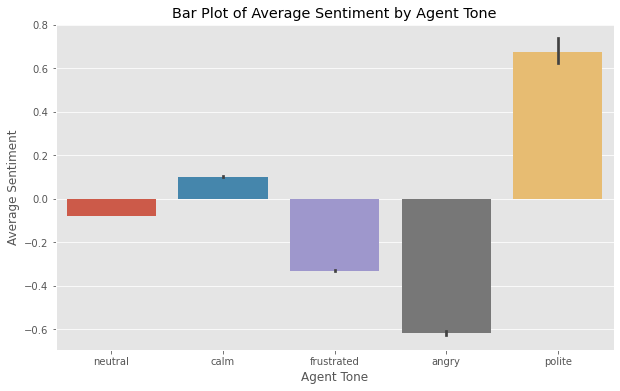

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='agent_tone', y='average_sentiment', data=calls_sentiment)
plt.title('Bar Plot of Average Sentiment by Agent Tone')
plt.xlabel('Agent Tone')
plt.ylabel('Average Sentiment')
plt.show()

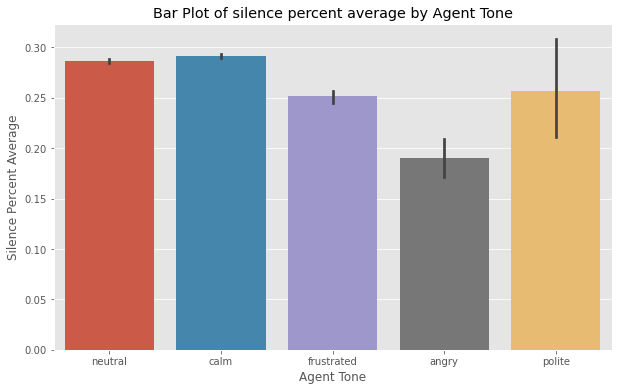

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x='agent_tone', y='silence_percent_average', data=calls_sentiment)
plt.title('Bar Plot of silence percent average by Agent Tone')
plt.xlabel('Agent Tone')
plt.ylabel('Silence Percent Average')
plt.show()

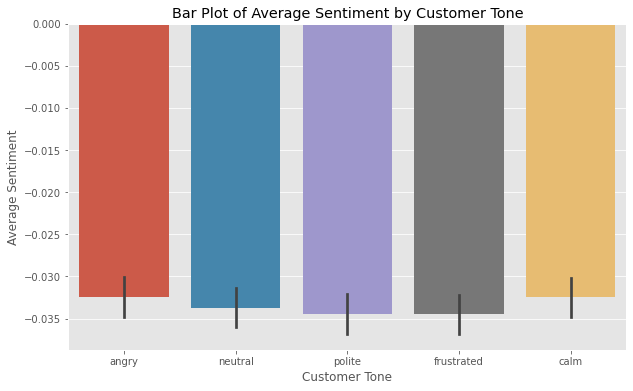

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x='customer_tone', y='average_sentiment', data=calls_sentiment)
plt.title('Bar Plot of Average Sentiment by Customer Tone')
plt.xlabel('Customer Tone')
plt.ylabel('Average Sentiment')
plt.show()

In [28]:
reason.head()

,call_id,primary_call_reason
0,4667960400,voluntary cancel
1,1122072124,booking
2,6834291559,irrops
3,2266439882,upgrade
4,1211603231,seating


In [29]:
reason['primary_call_reason'] = (reason['primary_call_reason']
                .str.lower()                                  # Convert to lowercase
                .str.strip()                                  # Remove leading and trailing spaces
                .str.replace(r'\s+', ' ', regex=True))

reason['primary_call_reason'].value_counts()

irrops                   13311
voluntary change         10848
seating                   6365
mileage plus              5851
post-flight               3957
communications            3840
products and services     2856
baggage                   2832
upgrade                   2738
booking                   2637
checkout                  1888
voluntary cancel          1607
check-in                  1519
digital support           1225
etc                        952
traveler updates           937
other topics               818
schedule change            731
products & services        476
disability                 403
check in                   385
post flight                373
unaccompanied minor        104
Name: primary_call_reason, dtype: int64

In [30]:
calls_reason = pd.merge(reason, calls_sentiment, on='call_id', how='outer')
calls_reason.head()

,call_id,primary_call_reason,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,voluntary cancel,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,31.0,7.0,neutral,angry,-0.04,0.39
1,1122072124,booking,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,12.0,3.0,calm,neutral,0.02,0.35
2,6834291559,irrops,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,19.0,8.0,neutral,polite,-0.13,0.32
3,2266439882,upgrade,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,7.0,5.0,neutral,frustrated,-0.20,0.20
4,1211603231,seating,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,9.0,10.0,neutral,polite,-0.05,0.35


In [31]:
df_test = calls_reason[['agent_tone','customer_tone','primary_call_reason',
                        'Handle_Time', 'Waiting_Time','average_sentiment',
                        'silence_percent_average']]

In [32]:
df_gr_reason = df_test.groupby(['agent_tone','customer_tone' ],
                              as_index = False).mean()


In [33]:
df_pivot = df_gr_reason.pivot(index='agent_tone', columns = 'customer_tone')
df_pivot

Handle_Time                                              \
customer_tone       angry       calm frustrated    neutral     polite   
agent_tone                                                              
angry            8.298701   5.882353   6.500000   5.787500   6.358974   
calm            10.273872  10.581906  10.491616  10.464379  10.395363   
frustrated      10.510929  10.133527   9.640789  10.902965  10.243101   
neutral         12.510675  12.500058  12.422872  12.744089  12.343205   
polite           5.666667   2.294118   3.375000   3.882353   3.052632   

              Waiting_Time                                           \
customer_tone        angry      calm frustrated   neutral    polite   
agent_tone                                                            
angry             7.389610  7.191176   7.244186  6.825000  6.782051   
calm              7.394352  7.360064   7.380164  7.425647  7.400244   
frustrated        7.062842  7.037736   7.094737  7.214286  6.956636   
neutral           7.222093  7.279159   7.236770  7.233314  7.232354   
polite            7.611111  8.882353   7.500000  7.294118  7.210526   

              average_sentiment                                           \
customer_tone             angry      calm frustrated   neutral    polite   
agent_tone                                                                 
angry                 -0.594675 -0.642500  -0.620465 -0.588375 -0.639744   
calm                   0.103685  0.100173   0.101585  0.099653  0.101379   
frustrated            -0.327773 -0.327417  -0.330105 -0.331307 -0.332996   
neutral               -0.080034 -0.080865  -0.080468 -0.079891 -0.080524   
polite                 0.675556  0.738235   0.674375  0.617059  0.664737   

              silence_percent_average                                           
customer_tone                   angry      calm frustrated   neutral    polite  
agent_tone                                                                      
angry                        0.235195  0.179265   0.186512  0.172000  0.177436  
calm                         0.295169  0.291233   0.288885  0.292575  0.289150  
frustrated                   0.256913  0.253890   0.236803  0.257493  0.252168  
neutral                      0.284452  0.285226   0.286138  0.290766  0.284795  
polite                       0.333889  0.200588   0.178125  0.281176  0.277368

In [34]:
# Create a contingency table
contingency_table = pd.crosstab(calls_reason['agent_tone'], 
                                calls_reason['customer_tone'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

# Interpretation
if p < 0.05:
    print("There is a statistically significant association between primary_call_reason and agent_tone.")
else:
    print("There is no statistically significant association between primary_call_reason and agent_tone.")

Chi-square statistic: 8.549295605214267
p-value: 0.9308087633775913
Degrees of freedom: 16
Expected frequencies:
[[  78.06298102   77.70980403   77.15015434   78.2803207    77.7967399 ]
 [4951.68137946 4929.27870043 4893.77907058 4965.46764348 4934.79320604]
 [ 739.29054517  735.94580476  730.64567765  741.34884695  736.76912547]
 [8580.50627855 8541.68586314 8480.17043566 8604.39576495 8551.2416577 ]
 [  17.45881581   17.37982764   17.25466177   17.50742391   17.39927088]]
There is no statistically significant association between primary_call_reason and agent_tone.


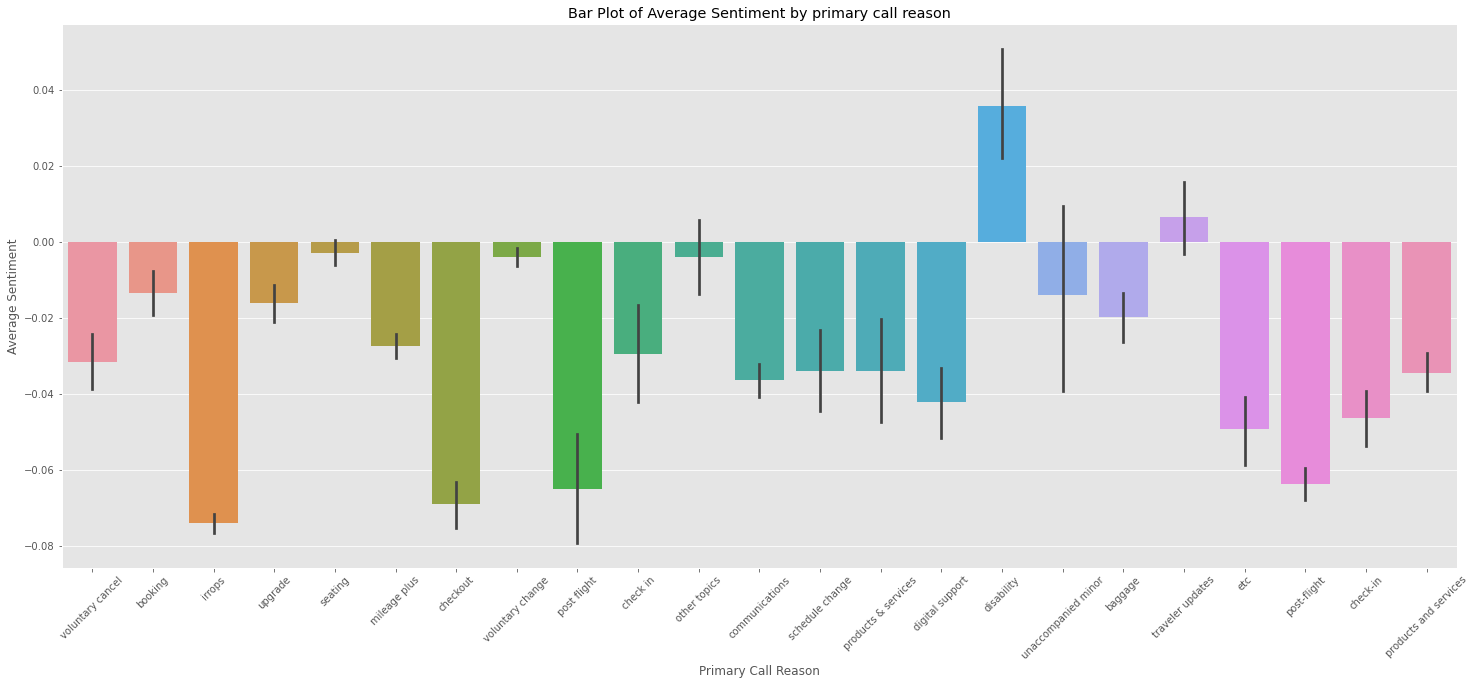

In [35]:
plt.figure(figsize=(25, 10))
sns.barplot(x='primary_call_reason', y='average_sentiment', data=calls_reason)
plt.title('Bar Plot of Average Sentiment by primary call reason')
plt.xlabel('Primary Call Reason')
plt.xticks(rotation=45)
plt.ylabel('Average Sentiment')
plt.show()

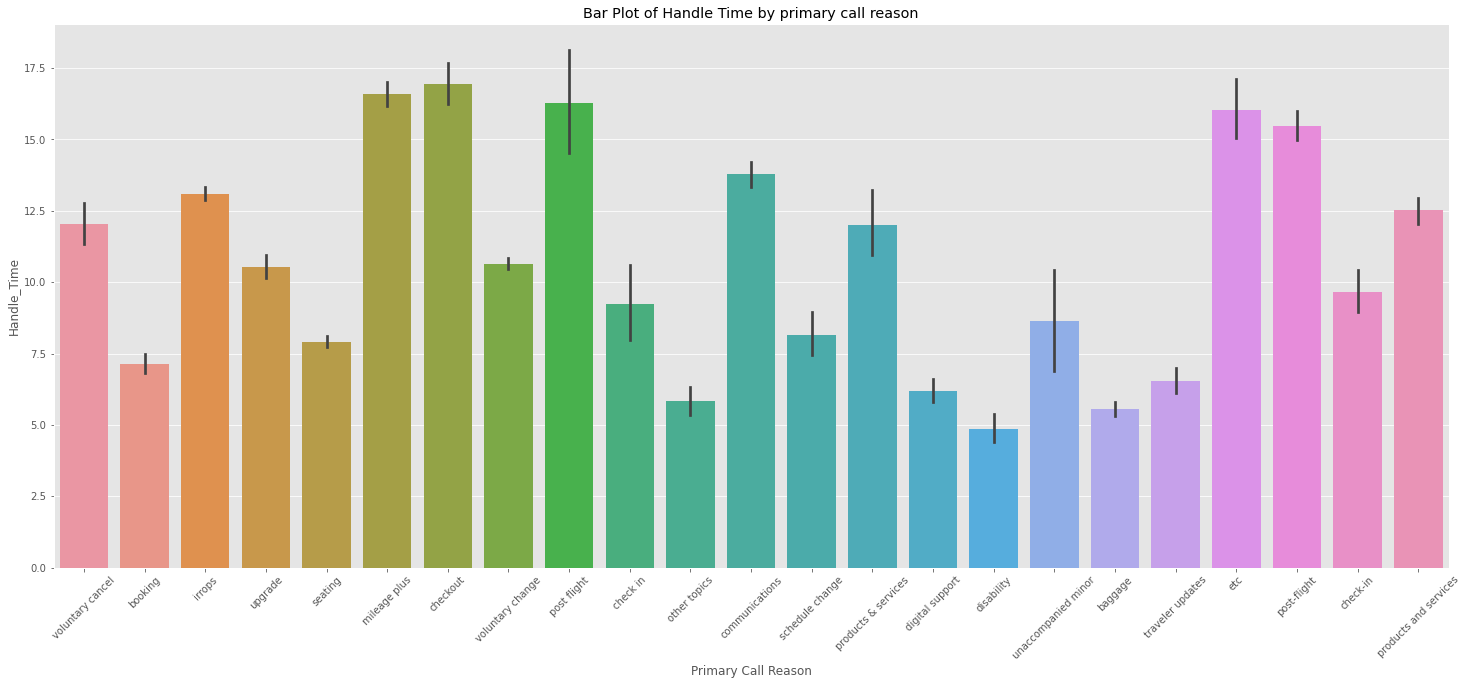

In [36]:
plt.figure(figsize=(25, 10))
sns.barplot(x='primary_call_reason', y='Handle_Time', data=calls_reason)
plt.title('Bar Plot of Handle Time by primary call reason')
plt.xticks(rotation=45)
plt.xlabel('Primary Call Reason')
plt.ylabel('Handle_Time')
plt.show()

-We can divide the IRROPS in following categories
- Flight Delays: Significant delays due to weather, technical issues, or crew rest requirements
- Flight Cancellations: Cancellations caused by maintenance problems, strikes, or other unforeseen events
- Missed Connections: When a delay or cancellation causes passengers to miss their connecting flights
- Diversions: Flights diverted to alternate airports due to emergencies or weather conditions
- Rebooking and Refunds: Assistance with rebooking flights or processing refunds for non-refundable tickets affected by   IRROPs

And then forward that call to agent accordingly to agent so that handling time reduces for these reasons as it takes significantly high time compared to others and average sentiment for these type of calls is lowest.

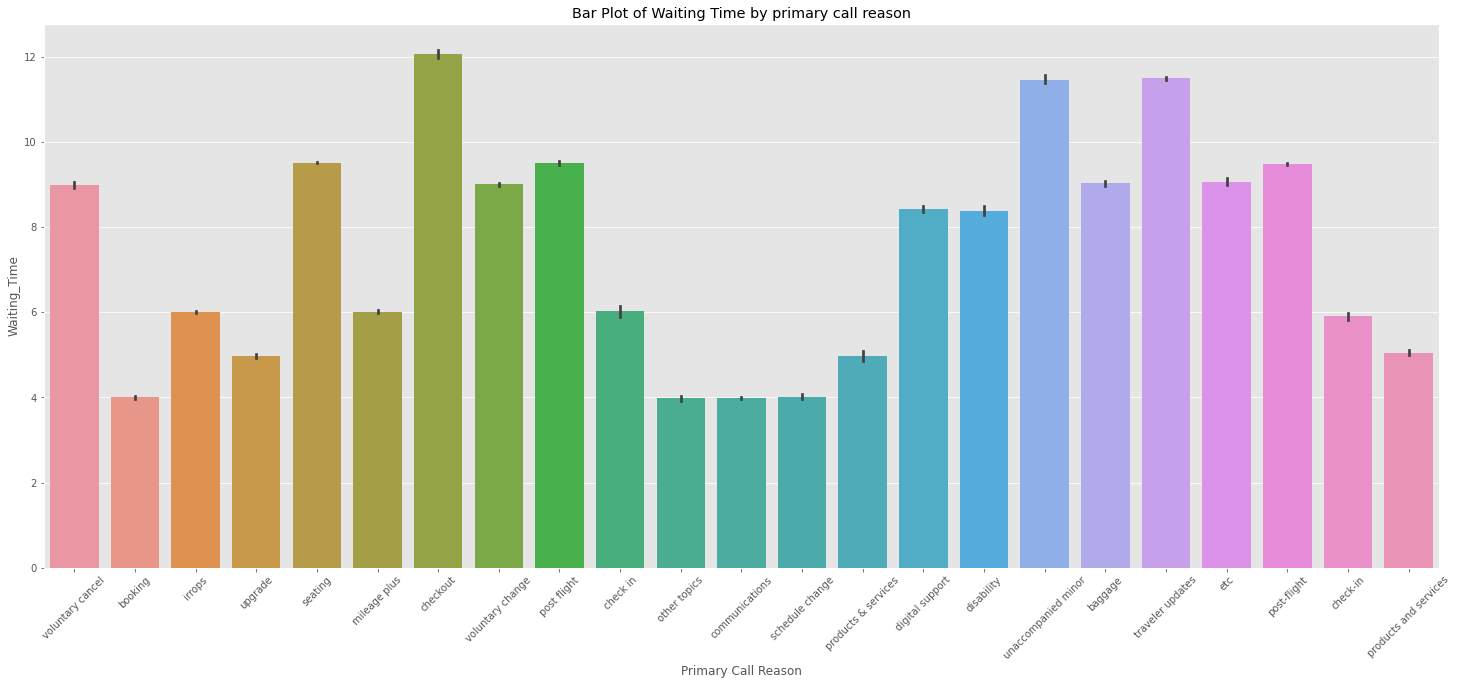

In [37]:
plt.figure(figsize=(25, 10))
sns.barplot(x='primary_call_reason', y='Waiting_Time', data=calls_reason)
plt.title('Bar Plot of Waiting Time by primary call reason')
plt.xlabel('Primary Call Reason')
plt.xticks(rotation=45)
plt.ylabel('Waiting_Time')
plt.show()

In [38]:
calls_reason.head()

,call_id,primary_call_reason,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,voluntary cancel,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,31.0,7.0,neutral,angry,-0.04,0.39
1,1122072124,booking,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,12.0,3.0,calm,neutral,0.02,0.35
2,6834291559,irrops,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,19.0,8.0,neutral,polite,-0.13,0.32
3,2266439882,upgrade,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,7.0,5.0,neutral,frustrated,-0.20,0.20
4,1211603231,seating,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,9.0,10.0,neutral,polite,-0.05,0.35


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import string
import re

STOPWORDS = set(stopwords.words('english'))


# Here we have split call transcript into agent conversation and customer conversation to check its predicted call reason, sentiment etc

In [40]:
def split_transcript(transcript):
    agent_lines = []
    customer_lines = []
    

    lines = transcript.split('\n')

    for line in lines:
        if line.startswith("Agent:"):
            agent_lines.append(line.replace("Agent:", "").strip())
        elif line.startswith("Customer:"):
            customer_lines.append(line.replace("Customer:", "").strip())
    
    agent_text = ' '.join(agent_lines)
    customer_text = ' '.join(customer_lines)
    
    return agent_text, customer_text

calls_reason[['agent_conversation', 'customer_conversation']] = calls_reason['call_transcript'].apply(
    lambda transcript: pd.Series(split_transcript(transcript))
)

print(calls_reason[['call_transcript', 'agent_conversation', 'customer_conversation']].head())

                                     call_transcript  \
0  \n\nAgent: Thank you for calling United Airlin...   
1  \n\nAgent: Thank you for calling United Airlin...   
2  \n\nAgent: Thank you for calling United Airlin...   
3  \n\nAgent: Thank you for calling United Airlin...   
4  \n\nAgent: Thank you for calling United Airlin...   

                                  agent_conversation  \
0  Thank you for calling United Airlines customer...   
1  Thank you for calling United Airlines, my name...   
2  Thank you for calling United Airlines customer...   
3  Thank you for calling United Airlines customer...   
4  Thank you for calling United Airlines customer...   

                               customer_conversation  
0  Hi, yeah I'm calling because my flight from Ch...  
1  Hi Sam, yeah I'm calling because I need to cha...  
2  Hi Steve, uh, I'm calling because I need to ma...  
3  Hi, yeah I'm calling because I'm having some i...  
4  Hi Sarah, thanks for taking my call. I'm calli..

In [41]:
from transformers import pipeline
from joblib import Parallel, delayed

sent_pipeline = pipeline('sentiment-analysis')

def get_sentiment(text):
    if pd.isna(text) or len(text.strip()) == 0:
        return {'label': 'NEUTRAL', 'score': 0}  # Handle empty or NaN values
    return sent_pipeline(text[:512])[0]  # Limit text to 512 characters

def parallel_sentiment_analysis(texts):
    return Parallel(n_jobs=-1)(delayed(get_sentiment)(text) for text in texts)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Below we have done sentiment analysis of first 1000 calls in the dataset.

In [42]:
calls_reason_subset = calls_reason.head(1000)

calls_reason_subset.reset_index(drop=True, inplace=True)

# calls_reason_subset.to_csv('calls_reason_subset.csv', index=False)

In [43]:
calls_reason_subset['agent_sentiment'] = calls_reason_subset['agent_conversation'].apply(lambda x: get_sentiment(x)['label'])
calls_reason_subset['agent_sentiment_score'] = calls_reason_subset['agent_conversation'].apply(lambda x: get_sentiment(x)['score'])

calls_reason_subset['customer_sentiment'] = calls_reason_subset['customer_conversation'].apply(lambda x: get_sentiment(x)['label'])
calls_reason_subset['customer_sentiment_score'] = calls_reason_subset['customer_conversation'].apply(lambda x: get_sentiment(x)['score'])

print(calls_reason_subset[['agent_conversation', 'agent_sentiment', 'agent_sentiment_score', 
                    'customer_conversation', 'customer_sentiment', 'customer_sentiment_score']].head())

C:\Users\Anjum\AppData\Local\Temp\ipykernel_58128\2386991849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_reason_subset['agent_sentiment'] = calls_reason_subset['agent_conversation'].apply(lambda x: get_sentiment(x)['label'])
C:\Users\Anjum\AppData\Local\Temp\ipykernel_58128\2386991849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_reason_subset['agent_sentiment_score'] = calls_reason_subset['agent_conversation'].apply(lambda x: get_sentiment(x)['score'])
C:\Users\Anjum\AppData\Local

                                  agent_conversation agent_sentiment  \
0  Thank you for calling United Airlines customer...        NEGATIVE   
1  Thank you for calling United Airlines, my name...        NEGATIVE   
2  Thank you for calling United Airlines customer...        NEGATIVE   
3  Thank you for calling United Airlines customer...        NEGATIVE   
4  Thank you for calling United Airlines customer...        NEGATIVE   

   agent_sentiment_score                              customer_conversation  \
0               0.998494  Hi, yeah I'm calling because my flight from Ch...   
1               0.988792  Hi Sam, yeah I'm calling because I need to cha...   
2               0.992585  Hi Steve, uh, I'm calling because I need to ma...   
3               0.932886  Hi, yeah I'm calling because I'm having some i...   
4               0.996007  Hi Sarah, thanks for taking my call. I'm calli...   

  customer_sentiment  customer_sentiment_score  
0           NEGATIVE                  0.999

C:\Users\Anjum\AppData\Local\Temp\ipykernel_58128\2386991849.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_reason_subset['customer_sentiment_score'] = calls_reason_subset['customer_conversation'].apply(lambda x: get_sentiment(x)['score'])


Text(0, 0.5, 'Count')

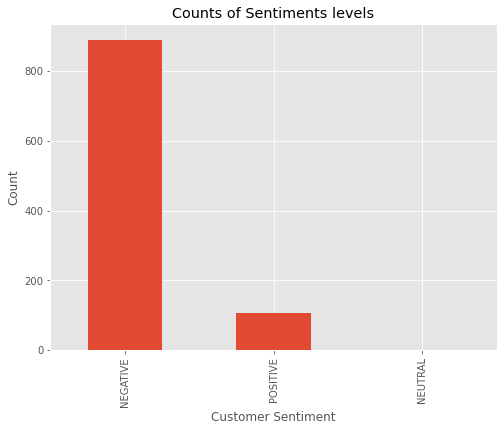

In [44]:
Sentiment = calls_reason_subset['customer_sentiment'].value_counts()
plt.figure(figsize=(8, 6))
Sentiment.plot(kind='bar')
plt.title('Counts of Sentiments levels')
plt.xlabel('Customer Sentiment')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

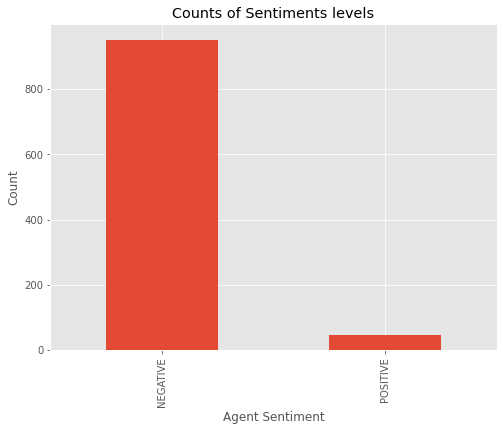

In [45]:
Sentiment = calls_reason_subset['agent_sentiment'].value_counts()
plt.figure(figsize=(8, 6))
Sentiment.plot(kind='bar')
plt.title('Counts of Sentiments levels')
plt.xlabel('Agent Sentiment')
plt.ylabel('Count')

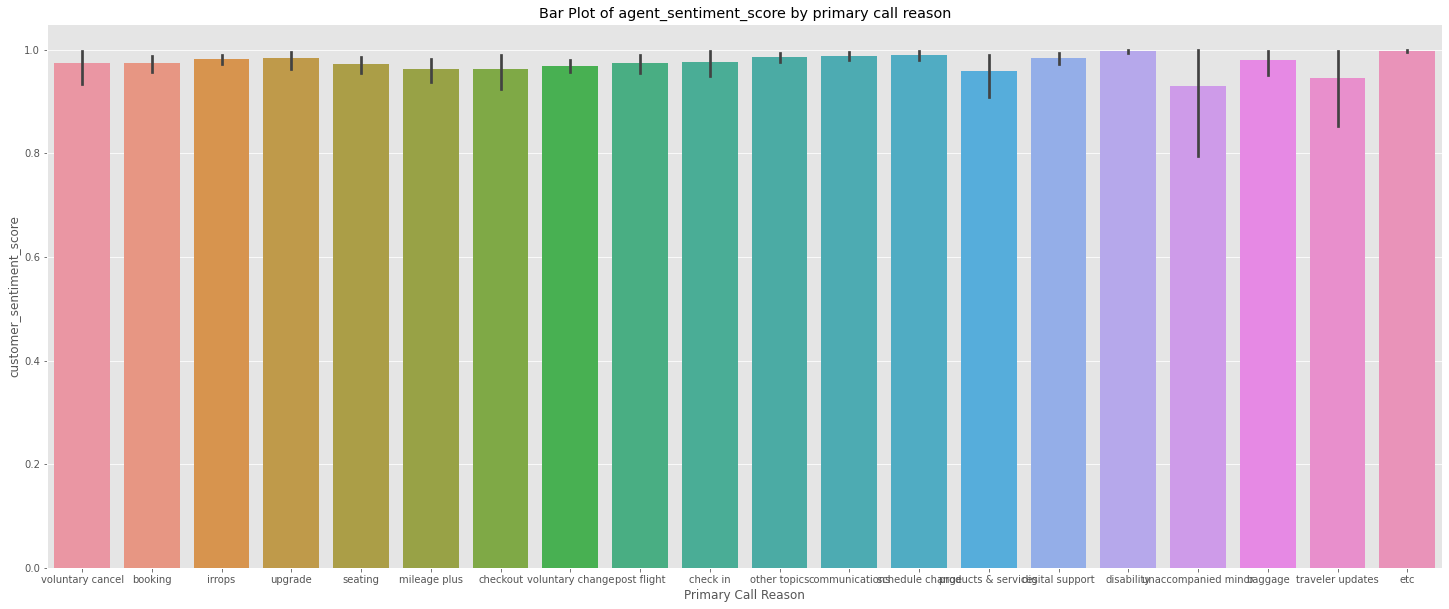

In [46]:
plt.figure(figsize=(25, 10))
sns.barplot(x='primary_call_reason', y='customer_sentiment_score', data=calls_reason_subset)
plt.title('Bar Plot of agent_sentiment_score by primary call reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('customer_sentiment_score')
plt.show()

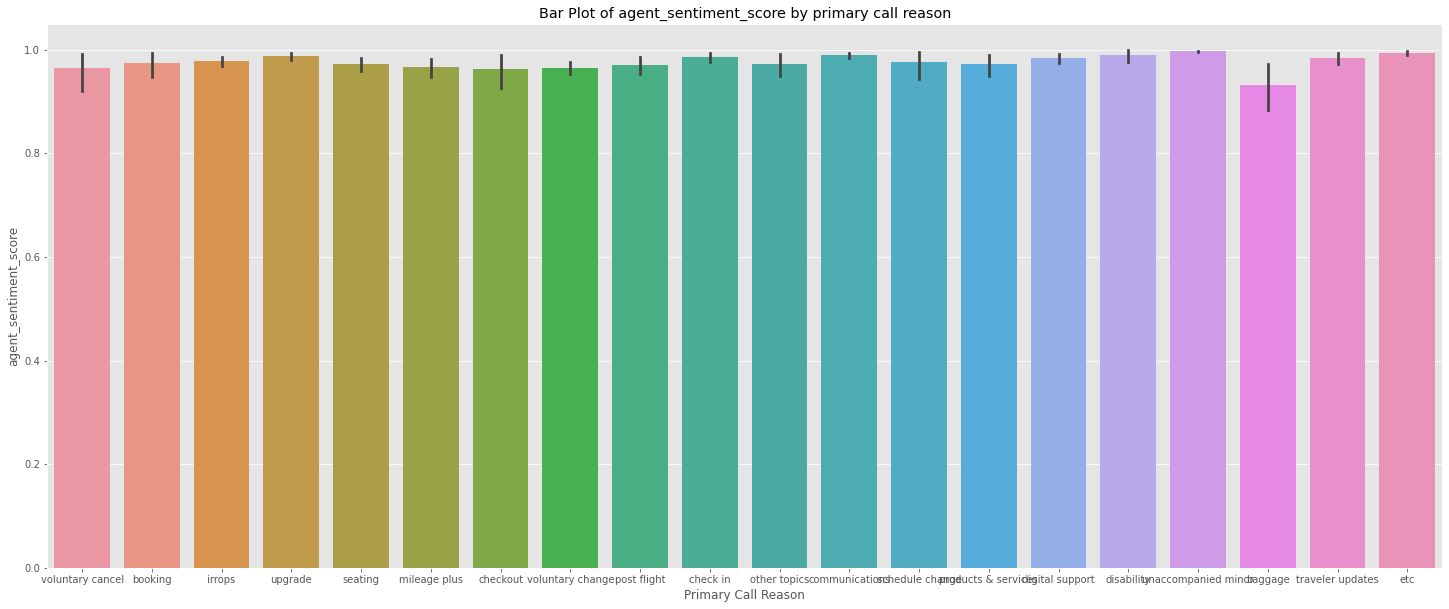

In [47]:
plt.figure(figsize=(25, 10))
sns.barplot(x='primary_call_reason', y='agent_sentiment_score', data=calls_reason_subset)
plt.title('Bar Plot of agent_sentiment_score by primary call reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('agent_sentiment_score')
plt.show()

# Analysing Call Reasons with Sentiment and Handling and Waiting Time

- Most Frequent Call Reason: irrops
- Average Handle Time: 13.09 minutes
- Least Frequent Call Reason: unaccompanied minor
- Average Handle Time: 8.65 minutes
- Percentage Difference in Average Handle Time for most frequet and least frequent call reasons: 51.21%

- Most Frequent Call Reason: irrops
- Average Waiting Time (Most Frequent): 6.001352265043948 minutes
- Least Frequent Call Reason: unaccompanied minor
- Average Waiting Time (Least Frequent): 11.471153846153847 minutes
- Percentage Difference in Waiting Time for most frequet and least frequent call reasons: -47.68%

In [48]:
average_handle_times = calls_reason.groupby('primary_call_reason')['Handle_Time'].mean().reset_index()

frequency_counts = calls_reason['primary_call_reason'].value_counts()

most_frequent_reason = frequency_counts.idxmax()
least_frequent_reason = frequency_counts.idxmin()

most_frequent_avg_time = average_handle_times.loc[average_handle_times['primary_call_reason'] == most_frequent_reason, 'Handle_Time'].values[0]
least_frequent_avg_time = average_handle_times.loc[average_handle_times['primary_call_reason'] == least_frequent_reason, 'Handle_Time'].values[0]

percentage_difference = ((most_frequent_avg_time - least_frequent_avg_time) / least_frequent_avg_time) * 100

print(f"Most Frequent Call Reason: {most_frequent_reason}")
print(f"Average Handle Time: {most_frequent_avg_time:.2f} minutes")
print(f"Least Frequent Call Reason: {least_frequent_reason}")
print(f"Average Handle Time: {least_frequent_avg_time:.2f} minutes")
print(f"Percentage Difference in Average Handle Time: {percentage_difference:.2f}%")


Most Frequent Call Reason: irrops
Average Handle Time: 13.09 minutes
Least Frequent Call Reason: unaccompanied minor
Average Handle Time: 8.65 minutes
Percentage Difference in Average Handle Time: 51.21%


In [49]:
avg_waiting_time = calls_reason.groupby('primary_call_reason')['Waiting_Time'].mean().reset_index()

call_reason_counts = calls_reason['primary_call_reason'].value_counts().reset_index()
call_reason_counts.columns = ['primary_call_reason', 'count']

most_frequent_reason = call_reason_counts.iloc[0]
least_frequent_reason = call_reason_counts.iloc[-1]

most_frequent_avg_waiting_time = avg_waiting_time.loc[avg_waiting_time['primary_call_reason'] == most_frequent_reason['primary_call_reason'], 'Waiting_Time'].values[0]
least_frequent_avg_waiting_time = avg_waiting_time.loc[avg_waiting_time['primary_call_reason'] == least_frequent_reason['primary_call_reason'], 'Waiting_Time'].values[0]

percentage_difference_waiting = ((most_frequent_avg_waiting_time - least_frequent_avg_waiting_time) / least_frequent_avg_waiting_time) * 100

print(f"Most Frequent Call Reason: {most_frequent_reason['primary_call_reason']}")
print(f"Average Waiting Time (Most Frequent): {most_frequent_avg_waiting_time} minutes")
print(f"Least Frequent Call Reason: {least_frequent_reason['primary_call_reason']}")
print(f"Average Waiting Time (Least Frequent): {least_frequent_avg_waiting_time} minutes")
print(f"Percentage Difference in Waiting Time: {percentage_difference_waiting:.2f}%")


Most Frequent Call Reason: irrops
Average Waiting Time (Most Frequent): 6.001352265043948 minutes
Least Frequent Call Reason: unaccompanied minor
Average Waiting Time (Least Frequent): 11.471153846153847 minutes
Percentage Difference in Waiting Time: -47.68%


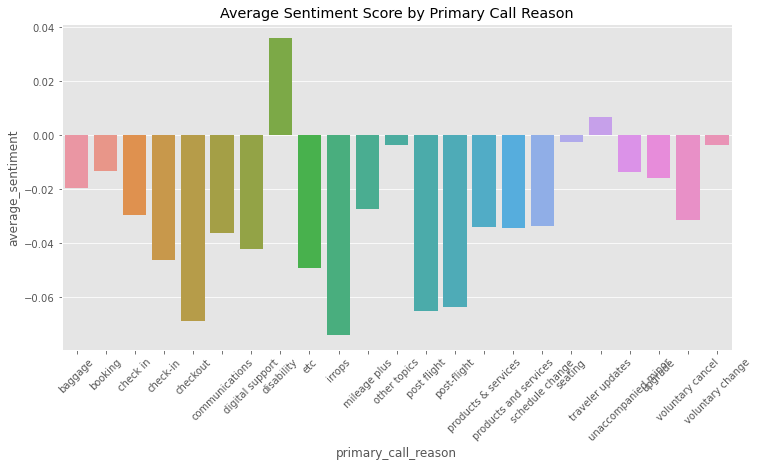

In [50]:
avg_sentiment = calls_reason.groupby('primary_call_reason')['average_sentiment'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sentiment, x='primary_call_reason', y='average_sentiment')
plt.title('Average Sentiment Score by Primary Call Reason')
plt.xticks(rotation=45)
plt.show()

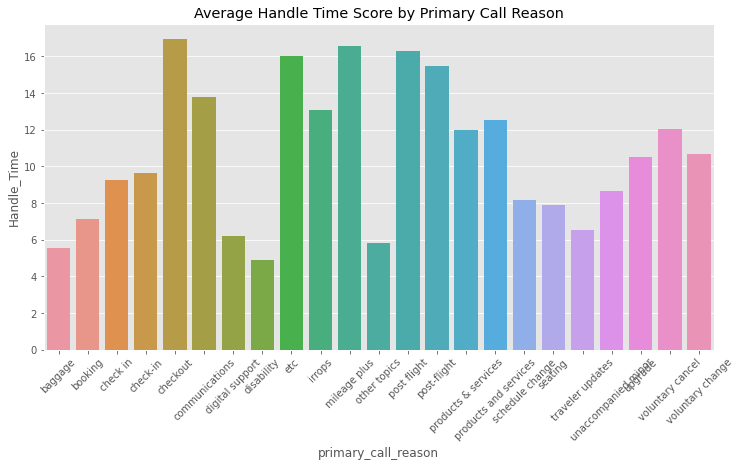

In [51]:
avg_sentiment = calls_reason.groupby('primary_call_reason')['Handle_Time'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sentiment, x='primary_call_reason', y='Handle_Time')
plt.title('Average Handle Time Score by Primary Call Reason')
plt.xticks(rotation=45)
plt.show()

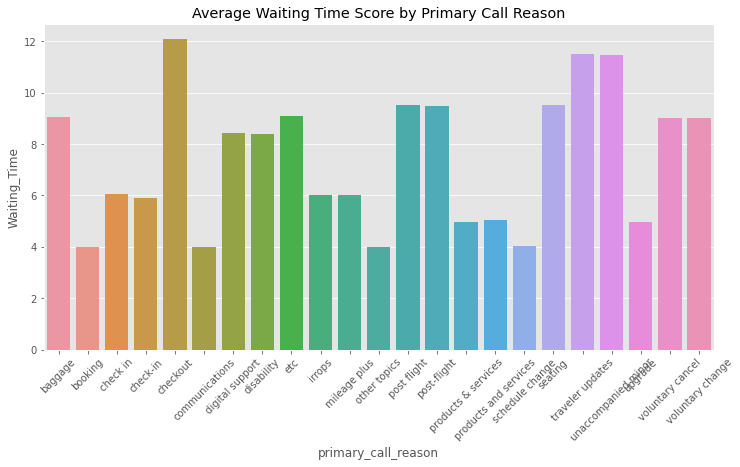

In [52]:
avg_sentiment = calls_reason.groupby('primary_call_reason')['Waiting_Time'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sentiment, x='primary_call_reason', y='Waiting_Time')
plt.title('Average Waiting Time Score by Primary Call Reason')
plt.xticks(rotation=45)
plt.show()

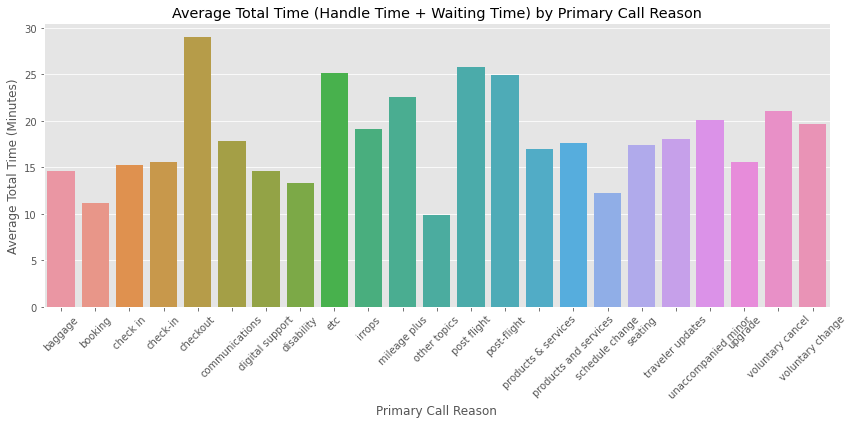

In [53]:
calls_reason['Total_Time'] = calls_reason['Handle_Time'] + calls_reason['Waiting_Time']
avg_total_time = calls_reason.groupby('primary_call_reason')['Total_Time'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_total_time, x='primary_call_reason', y='Total_Time')
plt.title('Average Total Time (Handle Time + Waiting Time) by Primary Call Reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('Average Total Time (Minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mileage Plus is United Airlines loyalty program. We need to ensure that those customers have less negative average sentiment score.

In [54]:
calls_reason = pd.merge(customers, calls_reason, on='customer_id', how='outer')
calls_reason.head()

,customer_id,customer_name,elite_level_code,call_id,primary_call_reason,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,silence_percent_average,agent_conversation,customer_conversation,Total_Time
0,2033123310,Matthew Foster,4.0,4667960400,voluntary cancel,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,31.0,7.0,neutral,angry,-0.04,0.39,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because my flight from Ch...",38.0
1,8186702651,Tammy Walters,NaN,1122072124,booking,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,12.0,3.0,calm,neutral,0.02,0.35,"Thank you for calling United Airlines, my name...","Hi Sam, yeah I'm calling because I need to cha...",15.0
2,2416856629,Jeffery Dixon,NaN,6834291559,irrops,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,19.0,8.0,neutral,polite,-0.13,0.32,Thank you for calling United Airlines customer...,"Hi Steve, uh, I'm calling because I need to ma...",27.0
3,1154544516,David Wilkins,2.0,2266439882,upgrade,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,7.0,5.0,neutral,frustrated,-0.20,0.20,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because I'm having some i...",12.0
4,5214456437,Elizabeth Daniels,0.0,1211603231,seating,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,9.0,10.0,neutral,polite,-0.05,0.35,Thank you for calling United Airlines customer...,"Hi Sarah, thanks for taking my call. I'm calli...",19.0


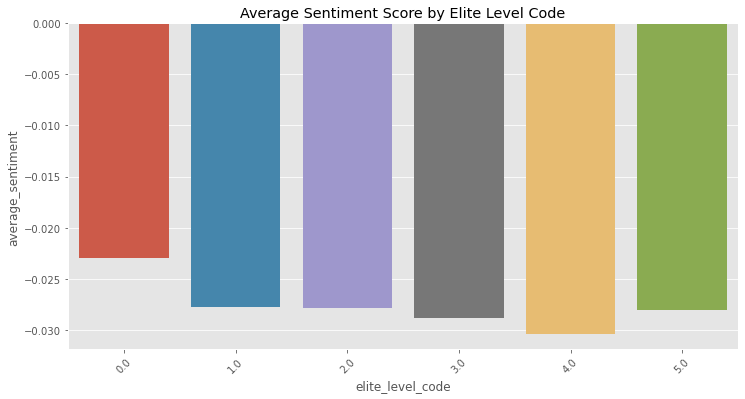

In [55]:
mileage_plus_df = calls_reason[calls_reason['primary_call_reason'] == 'mileage plus']

avg_sentiment = mileage_plus_df.groupby('elite_level_code')['average_sentiment'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sentiment, x='elite_level_code', y='average_sentiment')
plt.title('Average Sentiment Score by Elite Level Code')
plt.xticks(rotation=45)
plt.show()

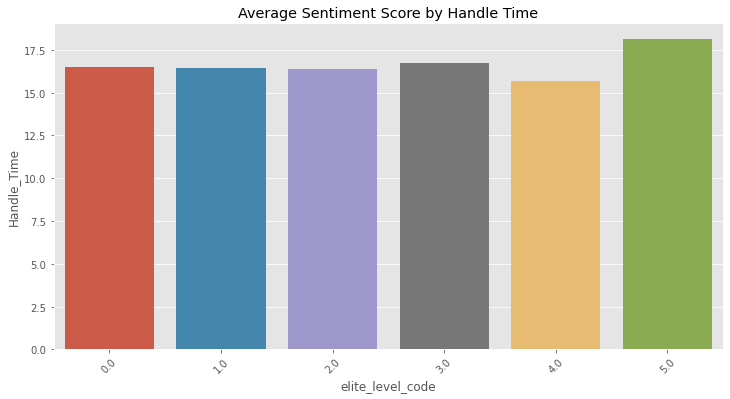

In [56]:
avg_sentiment = mileage_plus_df.groupby('elite_level_code')['Handle_Time'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sentiment, x='elite_level_code', y='Handle_Time')
plt.title('Average Sentiment Score by Handle Time')
plt.xticks(rotation=45)
plt.show()

In [57]:
calls_reason.to_csv('test.csv', index=False)

In [58]:
calls_reason.head()
# calls_reason.shape

,customer_id,customer_name,elite_level_code,call_id,primary_call_reason,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,silence_percent_average,agent_conversation,customer_conversation,Total_Time
0,2033123310,Matthew Foster,4.0,4667960400,voluntary cancel,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,31.0,7.0,neutral,angry,-0.04,0.39,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because my flight from Ch...",38.0
1,8186702651,Tammy Walters,NaN,1122072124,booking,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,12.0,3.0,calm,neutral,0.02,0.35,"Thank you for calling United Airlines, my name...","Hi Sam, yeah I'm calling because I need to cha...",15.0
2,2416856629,Jeffery Dixon,NaN,6834291559,irrops,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,19.0,8.0,neutral,polite,-0.13,0.32,Thank you for calling United Airlines customer...,"Hi Steve, uh, I'm calling because I need to ma...",27.0
3,1154544516,David Wilkins,2.0,2266439882,upgrade,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,7.0,5.0,neutral,frustrated,-0.20,0.20,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because I'm having some i...",12.0
4,5214456437,Elizabeth Daniels,0.0,1211603231,seating,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,9.0,10.0,neutral,polite,-0.05,0.35,Thank you for calling United Airlines customer...,"Hi Sarah, thanks for taking my call. I'm calli...",19.0


# PREDICTING CALL REASONS OF CALL IDs WHERE PRIMARY CALL REASON IS MISSING


For predicting call reasons we have split call transcript and trained aur model in customer conversation. 

In [59]:
calls_senti = calls_reason[['customer_id', 'call_id', 'primary_call_reason', 'Handle_Time', 
                            'Waiting_Time', 'agent_tone', 'customer_tone', 'average_sentiment', 
                            'agent_conversation', 'customer_conversation', 'Total_Time']]


In [60]:
calls_senti_cleaned = calls_senti.dropna(subset=['primary_call_reason'])
calls_senti_cleaned

,customer_id,call_id,primary_call_reason,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,agent_conversation,customer_conversation,Total_Time
0,2033123310,4667960400,voluntary cancel,31.0,7.0,neutral,angry,-0.04,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because my flight from Ch...",38.0
1,8186702651,1122072124,booking,12.0,3.0,calm,neutral,0.02,"Thank you for calling United Airlines, my name...","Hi Sam, yeah I'm calling because I need to cha...",15.0
2,2416856629,6834291559,irrops,19.0,8.0,neutral,polite,-0.13,Thank you for calling United Airlines customer...,"Hi Steve, uh, I'm calling because I need to ma...",27.0
3,1154544516,2266439882,upgrade,7.0,5.0,neutral,frustrated,-0.20,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because I'm having some i...",12.0
4,5214456437,1211603231,seating,9.0,10.0,neutral,polite,-0.05,Thank you for calling United Airlines customer...,"Hi Sarah, thanks for taking my call. I'm calli...",19.0
...,...,...,...,...,...,...,...,...,...,...,...
71804,7367304988,7569738090,mileage plus,10.0,6.0,neutral,frustrated,-0.19,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because I have a problem ...",16.0
71805,8022667294,1563273072,post flight,28.0,9.0,calm,calm,0.05,Thank you for calling United Airlines customer...,"Hi Dave, yeah I'm calling in about a flight I ...",37.0
71806,4474867021,8865997781,upgrade,8.0,3.0,calm,frustrated,0.03,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because I'm really not ha...",11.0
71807,9762042472,8019240181,upgrade,6.0,6.0,calm,polite,0.05,Thank you for calling United Airlines customer...,"Hi Steven, umm I was hoping you could help me ...",12.0


We have splitted the data on call_id where primary_call_reason is missing and stored it in file named calls_analysis and then aur model was trained on dataset named calls_senti for call reason. 


We have predicted the primary reason for customer service calls by analyzing customer conversations using Natural Language Processing (NLP). It first cleans the training data by removing rows with missing call reasons and then transforms the customer conversation text into numerical features using the TF-IDF (Term Frequency-Inverse Document Frequency) technique. A Logistic Regression model is trained on the processed text data and then used to predict call reasons for a test dataset. The final output is a CSV file containing the test data with predicted call reasons for further analysis.

In [61]:
test__0 = pd.read_csv('testcsv.csv')
print(test__0.head())
calls_analysis = pd.merge(calls_senti, test__0, on='call_id', how='right')
calls_analysis

      call_id
0  7732610078
1  2400299738
2  6533095063
3  7774450920
4  9214147168


,customer_id,call_id,primary_call_reason,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,agent_conversation,customer_conversation,Total_Time
0,4029953261,7732610078,NaN,58.0,11.0,neutral,neutral,-0.06,Thank you for calling United Airlines customer...,"Hi Sarah, um I'm calling about my upcoming fli...",69.0
1,2034858976,2400299738,NaN,13.0,8.0,calm,angry,0.01,"Thank you for calling United Airlines, my name...","Hello, yeah I'm calling because I have a compl...",21.0
2,1874845993,6533095063,NaN,2.0,10.0,neutral,calm,0.00,Thank you for calling United Airlines customer...,"Hi Alex, my name is John. I'm calling about a ...",12.0
3,2633426588,7774450920,NaN,4.0,4.0,calm,angry,0.02,"Thank you for calling United Airlines, this is...","Hi, I'm calling to complain about my recent fl...",8.0
4,8334856492,9214147168,NaN,4.0,6.0,neutral,frustrated,-0.12,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because I'm having some i...",10.0
...,...,...,...,...,...,...,...,...,...,...,...
5152,955491559,5300201106,NaN,13.0,3.0,neutral,polite,-0.15,Thank you for calling United Airlines customer...,"Hi Steve, umm yeah I'm calling about a flight ...",16.0
5153,5500822696,727694488,NaN,63.0,8.0,calm,frustrated,0.03,"Thank you for calling United Airlines, my name...","Hi, uh, yeah I'm calling because I have a flig...",71.0
5154,5121247144,147487837,NaN,5.0,5.0,neutral,frustrated,-0.14,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because I have a problem ...",10.0
5155,4211618675,5330794838,NaN,8.0,8.0,calm,calm,0.14,"Thank you for calling United Airlines, my name...","Hi Sam, yeah I'm calling about a flight I have...",16.0


In [62]:
calls_senti_cleaned = calls_senti.dropna(subset=['primary_call_reason'])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(calls_senti_cleaned['customer_conversation'])

X_test_tfidf = tfidf_vectorizer.transform(calls_analysis['customer_conversation'])

y_train = calls_senti_cleaned['primary_call_reason']

model = LogisticRegression(max_iter=500)

model.fit(X_train_tfidf, y_train)

calls_analysis['primary_call_reason'] = model.predict(X_test_tfidf)

calls_analysis[['call_id','primary_call_reason']].to_csv('test.csv', index=False)

In [64]:
calls_analysis.tail()

,customer_id,call_id,primary_call_reason,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,agent_conversation,customer_conversation,Total_Time
5152,955491559,5300201106,irrops,13.0,3.0,neutral,polite,-0.15,Thank you for calling United Airlines customer...,"Hi Steve, umm yeah I'm calling about a flight ...",16.0
5153,5500822696,727694488,irrops,63.0,8.0,calm,frustrated,0.03,"Thank you for calling United Airlines, my name...","Hi, uh, yeah I'm calling because I have a flig...",71.0
5154,5121247144,147487837,post-flight,5.0,5.0,neutral,frustrated,-0.14,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because I have a problem ...",10.0
5155,4211618675,5330794838,seating,8.0,8.0,calm,calm,0.14,"Thank you for calling United Airlines, my name...","Hi Sam, yeah I'm calling about a flight I have...",16.0
5156,8095620266,8332067080,mileage plus,4.0,6.0,neutral,polite,-0.07,Thank you for calling United Airlines customer...,"Hi Kelly, umm.. I'm calling about a flight I h...",10.0
